In [1]:
import sys
import argparse
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch

from model import MyModel
from utils import load_Lya_data, denormalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

opt:  Namespace(gpu_ids='1', load_iter=0, data_dir='./training_data', output_dir='./output/_bs64_ep10_lambda10_wgan', name='_bs64_ep10_lambda10_wgan', input_dim=256, output_dim=256, hidden_dim_G=64, hidden_dim_D=64, nlayer_G=4, nlayer_D=3, dropout=0.8, input_noise=True, batch_size=64, n_epochs=10, n_epochs_decay=0, epoch_count=1, lr=0.01, lr_policy='linear', lr_decay_iters=50, beta1=0.5, lambda_L1=10.0, lambda_z=2.0, gan_mode='wgan', print_freq=1, save_latest_freq=10000, save_image_freq=1000, save_image_irun=-1, norm_param_file='./output/_bs64_ep10_lambda10_wgan/norm_params.txt', n_feature_in=2, n_feature_out=1, model='vox2vox', isTrain=True)
loading the model from ./output/_bs64_ep10_lambda10_wgan/checkpoints/latest_net_G.pth
---------- Networks initialized --------------------
[Network G] Total number of parameters : 24,663,425
DataParallel(
  (module): UnetGenerator(
    (model): UnetSkipConnectionBlock3D(
      (model): Sequential(
        (0): Conv3d(3, 64, kernel_size=(4, 4, 4), 

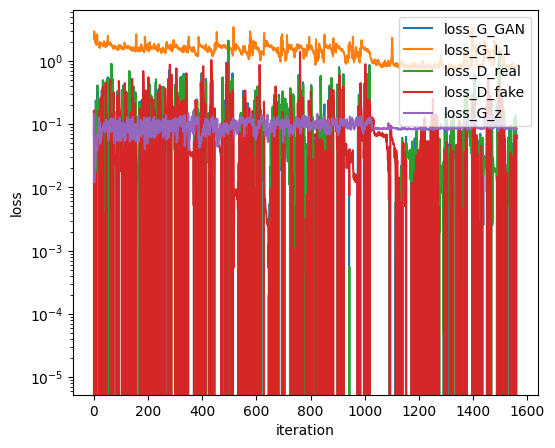

In [7]:
model_dir = "./output/_bs64_ep10_lambda10_vanilla"
model_dir = "./output/_bs64_ep10_lambda10_wgan"

# loss function
fname = f"{model_dir}/loss_log.txt"
df = pd.read_csv(fname, sep=" ", header=0)
header = df.columns

plt.figure(figsize=(6,5))
plt.xlabel("iteration")
plt.ylabel("loss")

epoch = df["#iter"]
key_list = header[4:]
for i, key in enumerate(key_list):
    plt.plot(epoch, df[key], label=key)
plt.legend(loc="upper right")
plt.yscale("log")

# load arguments
with open(f"{model_dir}/args.json", "r") as f:
    opt = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
print("opt: ", opt)

norm_param_file = f"{model_dir}/norm_params.txt"

### load model
opt.isTrain = False
opt.load_iter = -1 # -1: latest
model = MyModel(opt)
model.setup(opt)
model.eval()
print(model)

generator = model.netG

for m in generator.modules():
    if isinstance(m, torch.nn.Dropout):
        m.train()  # Dropout だけ train mode に切り替え


In [3]:
source, target, _, _ = load_Lya_data(opt.data_dir, ndata=1, nval=0, n_feature_in=opt.n_feature_in, norm_param_file=opt.norm_param_file, device=device)

# shape:  (2, 128, 128, 1024)
# Load statistics from ./output/_bs64_ep10_lambda1_vanilla/norm_params.txt


source shape:  torch.Size([1, 2, 16, 16, 16])


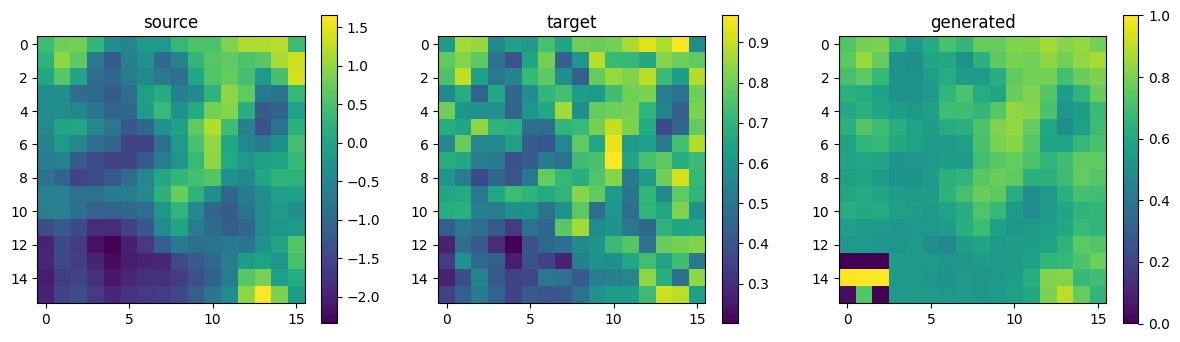

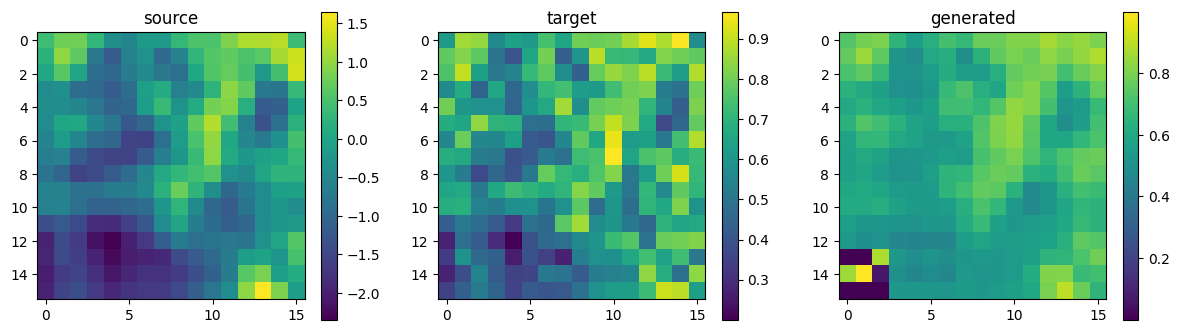

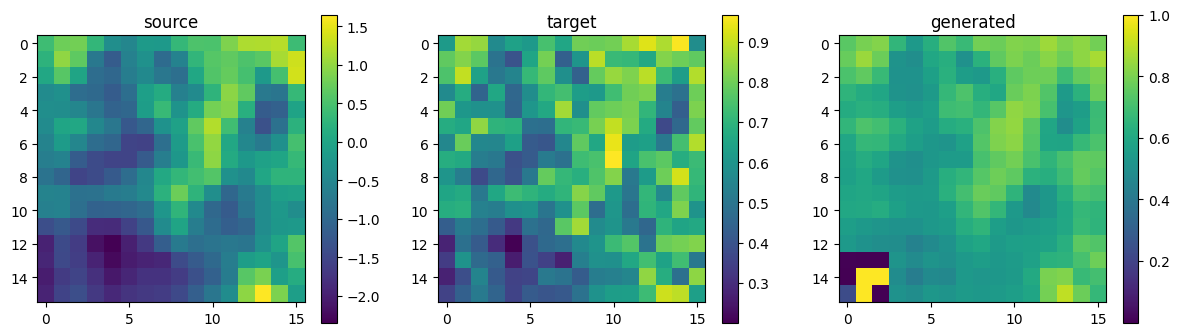

In [8]:
show_original_data = False 
#show_original_data = True

print("source shape: ", source.shape)
for _ in range(3):
    if opt.input_noise:
        noise = torch.randn(source.shape[0], 1, source.shape[2], source.shape[3], source.shape[4]).to(device)
        source_with_noise = torch.cat([source, noise], dim=1)
        generated = generator(source_with_noise)
    else:
        generated = generator(source)

    source_npy = source.detach().cpu().numpy()
    target_npy = target.detach().cpu().numpy()
    generated_npy = generated.detach().cpu().numpy()

    std = 0.096
    noise = np.random.normal(0, std, size=target_npy.shape)
    gen_with_noise = generated_npy + noise

    if show_original_data:
        source_npy, target_npy = denormalize(opt.n_feature_in, source=source_npy, target=target_npy, norm_param_file=norm_param_file)
        _, generated_npy = denormalize(opt.n_feature_in, target=generated_npy, norm_param_file=norm_param_file)   
        _, gen_with_noise = denormalize(opt.n_feature_in, target=gen_with_noise, norm_param_file=norm_param_file)
        source_npy = 10 ** source_npy
        target_npy = 10 ** target_npy
        generated_npy = 10 ** generated_npy
        gen_with_noise = 10 ** gen_with_noise

    nmap = 5


    plt.figure(figsize=(nmap*5,4))
    plt.subplot(1,nmap,1)
    plt.title("source")
    plt.imshow(source_npy[0,0,:,:,0])
    plt.colorbar()

    plt.subplot(1,nmap,2)
    plt.title("target")
    plt.imshow(target_npy[0,0,:,:,0]) # vmin=0, vmax=1)
    plt.colorbar()

    plt.subplot(1,nmap,3)
    plt.title("generated")
    plt.imshow(generated_npy[0,0,:,:,0]) #, vmin=0, vmax=1)
    plt.colorbar()

    """
    plt.subplot(1,nmap,4)
    plt.title("diff")
    diff = target_npy - generated_npy
    plt.imshow(diff[0,0,:,:,0]) #, vmin=0, vmax=1)
    plt.colorbar()

    plt.subplot(1,nmap,5)
    plt.title("generated + noise")
    plt.imshow(gen_with_noise[0,0,:,:,0]) #, vmin=0, vmax=1)
    plt.colorbar()
    """

    #plt.figure()
    #std = np.std(diff.flatten())
    #plt.hist(diff.flatten(), bins=100)
    #plt.title(f"std: {std:.3f}")
    #plt.figure()
    #plt.scatter(generated_npy.flatten(), diff.flatten(), s=1)

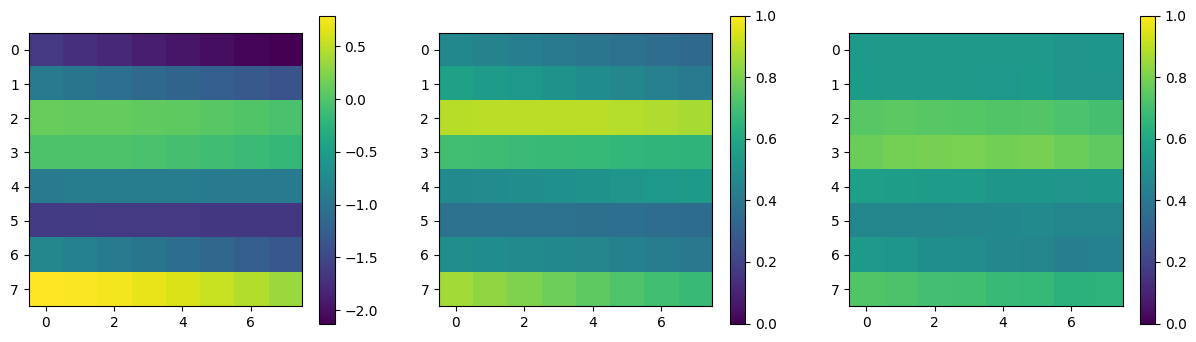

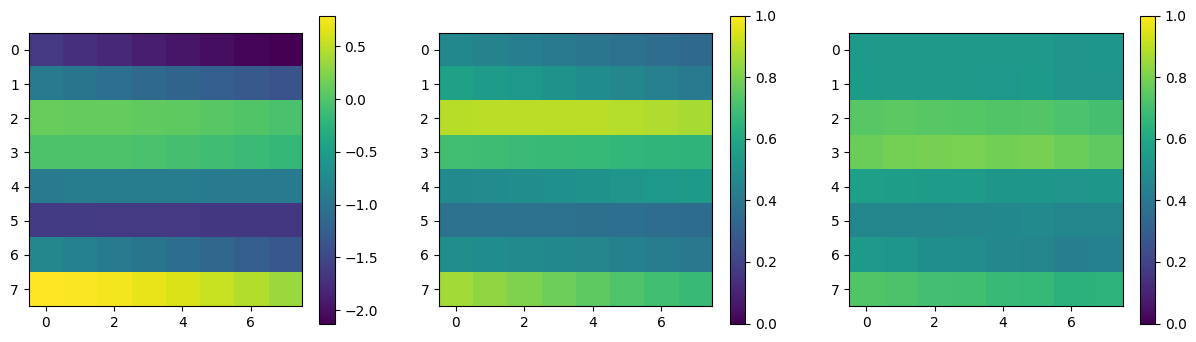

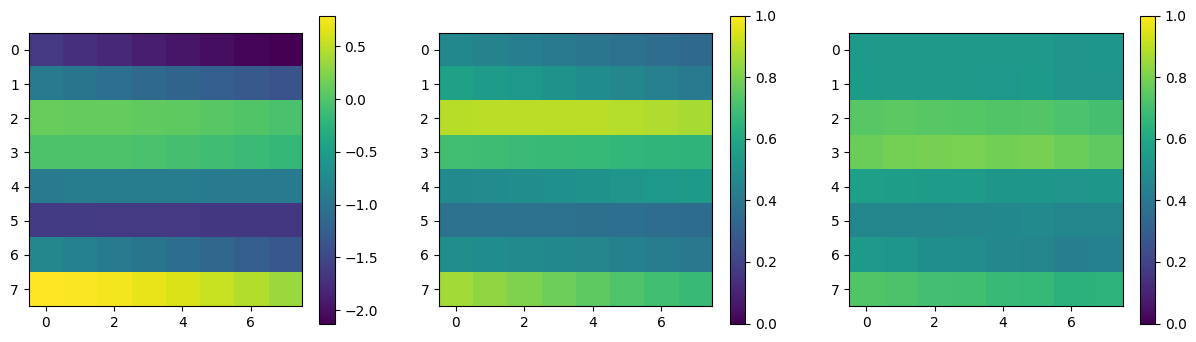

In [13]:
for _ in range(3):
    generated = generator(source)

    source_npy = source.detach().cpu().numpy()
    target_npy = target.detach().cpu().numpy()
    generated_npy = generated.detach().cpu().numpy()

    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.imshow(source_npy[0,0,0,:,:])
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.imshow(target_npy[0,0,0,:,:], vmin=0, vmax=1)
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.imshow(generated_npy[0,0,0,:,:], vmin=0, vmax=1)
    plt.colorbar()

In [6]:
rho, flux, _, _ = load_Lya_data(opt.data_dir, ndata=1, npix_patch=[127, 127,1023], nval=0, n_feature_in=1, norm_param_file=None, device=device)
rho = rho[0,0,:,:,:].detach().cpu().numpy()
flux = flux[0,0,:,:,:].detach().cpu().numpy()

# shape:  (1, 128, 128, 1024)
# No normalization


Fitted factor: 11.6509
Fitted beta: -1.0153


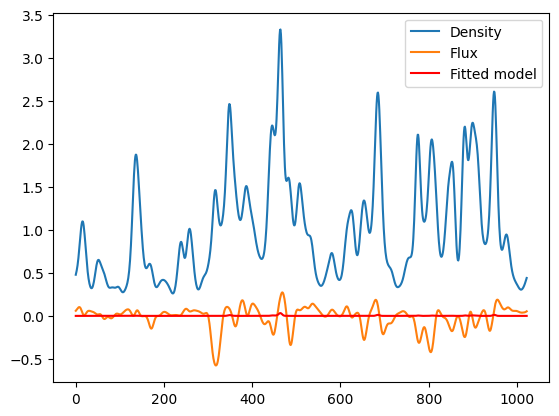

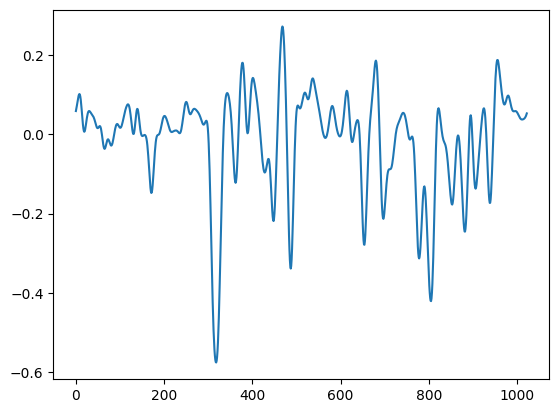

In [9]:
from scipy.optimize import curve_fit

def flux_model(rho, factor, beta):
    return np.exp(-factor * rho ** beta)

initial_guess = [1.0, 1.0]  # 初期値
rho_flattened = rho.flatten()
flux_flattened = flux.flatten()
popt, pcov = curve_fit(flux_model, rho_flattened, flux_flattened, p0=initial_guess)
fitted_factor, fitted_beta = popt

print(f"Fitted factor: {fitted_factor:.4f}")
print(f"Fitted beta: {fitted_beta:.4f}")

plt.plot(rho[0,0,:], label='Density')
plt.plot(flux[0,0,:], label='Flux')

flux_model = flux_model(rho[0,0,:], *popt)
plt.plot(flux_model, color='red', label='Fitted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(flux[0,0,:])

